In [32]:
%load_ext autoreload
%autoreload 2

import icon_registration
import icon_registration.data as data
import icon_registration.networks as networks
import icon_registration.network_wrappers as network_wrappers
import icon_registration.visualize as visualize
import icon_registration.train as train
import icon_registration.config as config
import icon_registration.inverseConsistentNet as inverseConsistentNet
from icon_registration.mermaidlite import compute_warped_image_multiNC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import os
import pickle
from IPython.display import Image, display
import torch.nn.functional as F

In [35]:
import inspect
lines = inspect.getsource(data.get_dataset_retina)
print(lines)

def get_dataset_retina(
    extra_deformation=False,
    downsample_factor=4,
    blur_sigma=None,
    warps_per_pair=20,
    fixed_vertical_offset=None,
    include_boundary=False,
):
    try:
        import elasticdeform
        import hub
    except:

        raise Exception(
            """the retina dataset requires the dependencies hub and elasticdeform.
            Try pip install hub elasticdeform"""
        )

    ds_name = f"retina{extra_deformation}{downsample_factor}{blur_sigma}{warps_per_pair}{fixed_vertical_offset}{include_boundary}.trch"

    import os

    if os.path.exists(ds_name):
        augmented_ds1_tensor, augmented_ds2_tensor = torch.load(ds_name)
    else:

        res = []
        for batch in hub.load("hub://activeloop/drive-train").pytorch(
            num_workers=0, batch_size=4, shuffle=False
        ):
            if include_boundary:
                res.append(batch["manual_masks/mask"] ^ batch["masks/mask"])
            else:
                res.append(

In [37]:
d1, d2 = data.get_dataset_retina(extra_deformation=False, downsample_factor=5, warps_per_pair=20)

Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/drive-train loaded successfully.
This dataset can be visualized at https://app.activeloop.ai/activeloop/drive-train.
warping images to generate dataset


100%|██████████| 20/20 [01:32<00:00,  4.62s/it]


In [4]:
# Load loss for retina
output_folder = 'figures/comparing_to_other_regularity/retina'
with open(f'{output_folder}/retina_exp_loss_curve.pickle', 'rb') as f:
    retina_loss = pickle.load(f)

In [6]:
# Load loss for circle
output_folder = 'figures/comparing_to_other_regularity/circle_128'
with open(f'{output_folder}/exp_loss_curve.pickle', 'rb') as f:
    circle_loss = pickle.load(f)

In [7]:
def get_loss_curve(result):
    return np.array(result)[:,:,:,-3], np.array(result)[:,:,:,-2], np.array(result)[:,:,:,-1]

In [26]:
models = [
    [retina_loss, "ICON", 10, 292*282, '-', 0, "DRIVE"],
    [retina_loss, "GradICON", 5, 292*282, '-', 1, "DRIVE"],
    [circle_loss, "ICON", 8, 128*128, '--', 0, "T&C"],
    [circle_loss, "GradICON", 3, 128*128, '--', 1, "T&C"]
]

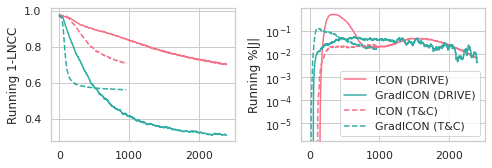

In [28]:
import seaborn as sns

output_folder = 'figures/comparing_to_other_regularity'
fig, axes = plt.subplots(1, 2, figsize=(7,2.5))
sns.set(style="whitegrid")
clrs = sns.color_palette("husl", 2)

for i, (loss_data, name, ite, vol, linestyle, color_id, dataset_name) in enumerate(models):
    sim_loss, mag_loss, fold_loss = get_loss_curve(loss_data[name])
    fold_smooth = fold_loss[ite, 0]/vol*100.0
    fold_smooth = [np.mean(fold_smooth[max(j-40,0):j+1]) for j in range(fold_smooth.shape[0])]
    sim_smooth = sim_loss[ite, 0]/2.0
    sim_smooth = [np.mean(sim_smooth[max(j-40,0):j+1]) for j in range(sim_smooth.shape[0])]
    axes[0].plot(sim_smooth, label=name+f" ({dataset_name})", lw=1.5, c=clrs[color_id], linestyle=linestyle)#, alpha=0.8**i)
    axes[0].set_ylabel('Running 1-LNCC')
    axes[1].plot(fold_smooth, label=name+f" ({dataset_name})", lw=1.5, c=clrs[color_id], linestyle=linestyle)#, alpha=0.8**i)
    axes[1].set_ylabel('Running %|J|')
    axes[1].set_yscale('log')
    
    axes[1].legend()

# x_left, x_right = axes[1].get_xlim()
# y_low, y_high = axes[1].get_ylim()
# axes[1].set_aspect(abs((x_right-x_left)/(y_low-y_high)))
# x_left, x_right = axes[0].get_xlim()
# y_low, y_high = axes[0].get_ylim()
# axes[0].set_aspect(abs((x_right-x_left)/(y_low-y_high)))

plt.tight_layout()
plt.savefig(f'{output_folder}/convergence_speed_combined.pdf', format='pdf', bbox_inches='tight', dpi=300)